In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import xgboost as xgb
from shared_funcs import clean_time1, clean_time2, fourwks_n
import shap
from scipy import stats
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

# Predicting Daily Yield - Station 1
    We use the results found in solar_investigation to develop a model for predicting the next few days of power yield to allow for better grid management.
    
    The Weather and station data is collected over a period of 32 days. Using the fact that weather predictions become increasingly more accurate the closer to the day you are, as well as how much instrument precision you can get; This model is going to attempt to predict the final four days of daily yield for each inverter at station 1 assuming the data that received is also predicted as a mean over for an entire day.
    
    For this the data we are interested in using to predict the daily yield are irradiance, module temp, ambient temp, ac power, dc power, and the particular inverter. All values are considered as means for the day where ac and dc power as well as module temperature is also somewhat forecasted based on the irradiance values.

In [2]:
df_gen1 = pd.read_csv('Plant_1_Generation_Data.csv')
df_wea1 = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

In [3]:
df_gen1['DC_POWER'] = df_gen1['DC_POWER']/10
df_gen1 = clean_time1(df_gen1,'DATE_TIME').drop(['DATE_TIME'],axis=1)
df_wea1 = clean_time2(df_wea1,'DATE_TIME').drop(['SOURCE_KEY','DATE_TIME'],axis=1)
result1 = pd.merge(df_gen1, df_wea1, how='outer', on=['DATE','HOUR','MINUTE']).dropna()
result1

,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE,HOUR,MINUTE,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0,2020-05-15,0,0,25.184316,22.857507,0.0
1,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0,2020-05-15,0,0,25.184316,22.857507,0.0
2,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0,2020-05-15,0,0,25.184316,22.857507,0.0
3,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0,2020-05-15,0,0,25.184316,22.857507,0.0
4,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0,2020-05-15,0,0,25.184316,22.857507,0.0
...,...,...,...,...,...,...,...,...,...,...,...
68773,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0,2020-06-17,23,45,21.909288,20.427972,0.0
68774,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0,2020-06-17,23,45,21.909288,20.427972,0.0
68775,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0,2020-06-17,23,45,21.909288,20.427972,0.0
68776,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0,2020-06-17,23,45,21.909288,20.427972,0.0


Applying the same cleaning to the sheets which are relative straightforward already, we then create a new DataFrame where the information is preprocessed to suit our needs. Furthermore this is where we develop the mean values for all continuous features leading to the maximal value for the daily yield as our target.

In [4]:
res1_means = result1.groupby(['SOURCE_KEY','DATE'])[['AC_POWER','DC_POWER','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','IRRADIATION']].agg('mean').reset_index()
res1_max = result1.groupby(['SOURCE_KEY','DATE'])[['DAILY_YIELD']].agg('max').reset_index()
res1_information = pd.merge(res1_means, res1_max, how='outer', on=['SOURCE_KEY','DATE'])
res1_nopp = res1_information.copy()
res1_information['SOURCE_KEY'] = label_encoder.fit_transform(res1_information['SOURCE_KEY'])
res1_information

,SOURCE_KEY,DATE,AC_POWER,DC_POWER,MODULE_TEMPERATURE,AMBIENT_TEMPERATURE,IRRADIATION,DAILY_YIELD
0,0,2020-05-15,247.812372,253.054512,32.582964,27.430823,0.204699,5754.0
1,0,2020-05-16,285.505580,291.624858,31.858851,26.780538,0.211951,6292.0
2,0,2020-05-17,293.467187,300.041481,32.740435,26.686727,0.238869,7045.0
3,0,2020-05-18,208.026116,212.531566,27.814344,23.850938,0.159026,4998.0
4,0,2020-05-19,244.528783,249.760503,29.725163,25.338021,0.194031,6449.0
...,...,...,...,...,...,...,...,...
743,21,2020-06-13,345.271019,353.333278,30.481026,24.566729,0.264472,8410.0
744,21,2020-06-14,305.418062,312.013263,29.421707,24.412891,0.220086,7320.0
745,21,2020-06-15,285.134654,291.455822,29.927817,24.827414,0.205925,6820.0
746,21,2020-06-16,260.423214,266.038058,29.555567,24.928929,0.187283,6262.0


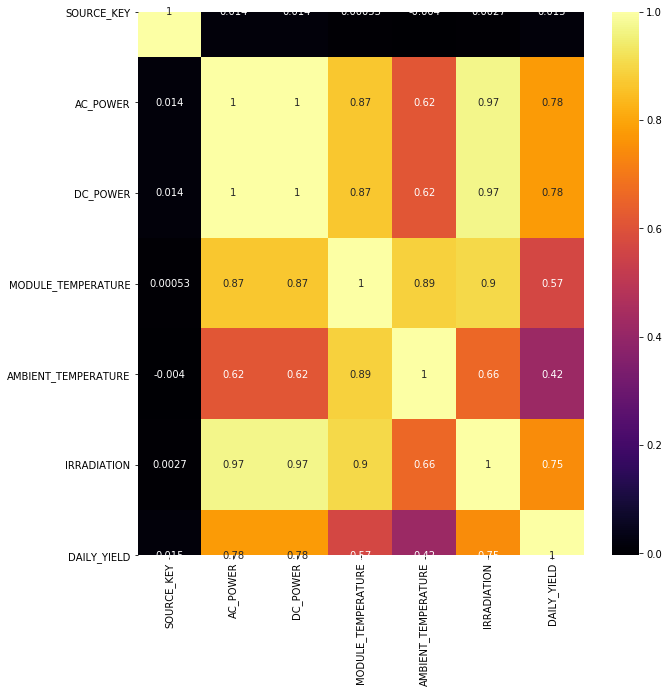

In [5]:
plt.figure(figsize=(10,10))
c = res1_information.corr(method='pearson')
sns.heatmap(c,cmap='inferno',annot=True)

Creating a data set where the mean values 'measured' for the features to the max target values on a particular day provide an increase to the correlation values.  

In [6]:
X = res1_information[['SOURCE_KEY','IRRADIATION','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','DC_POWER','AC_POWER']]
y = res1_information[['DAILY_YIELD']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=4)

model_data, external_data = fourwks_n(res1_information,4)#splitting data into first 28days last 4 days
X_in = model_data[['SOURCE_KEY','IRRADIATION','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','DC_POWER','AC_POWER']]
y_in = model_data[['DAILY_YIELD']]
X_external = external_data[['SOURCE_KEY','IRRADIATION','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','DC_POWER','AC_POWER']]
y_external = external_data[['DAILY_YIELD']]

Here we split the dataset into two different sets. First we have the typical 75/25 train/test random splitting of the entire data set.Using this we perform a k-fold cross validation using random search to determine the best hyperparameters for our model based on a random selection from the entire dataset.

The second set of data is a split into the first 28days and last 4 days. For this we assume the values to approximated values that could be based on weather forecast data. In theory since irradiation has such a high correlation to the othe features one could develop mean values for each inverter on the upcomming days.

Once the hyperparameters have been determined from the entire set these will be used to train the second set.

In [7]:
reg_xgb = xgb.XGBRegressor(n_estimators=5000,objective='reg:squarederror')
params = {
    'learning_rate': stats.uniform(0.01,0.2),
    'min_child_weight': [2,4,8,10,12,14,16,20],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'colsample_bytree': [0.5,0.6,0.7,0.8,0.9,1.0],
    'max_depth': [3,4,5,6,7,8,9,10],
    'alpha': [0.01, 0.1, 1, 10, 100]
}

In [8]:
numfolds = 21
kfolds = KFold(n_splits=numfolds, shuffle = True, random_state=4)

In [9]:
random_search = RandomizedSearchCV(reg_xgb, params, n_jobs=4, n_iter= 10,cv = kfolds.split(X,y), scoring='neg_root_mean_squared_error')
random_search.fit(X,y)
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 All results:
{'mean_fit_time': array([2.60753756, 2.50930081, 3.27095347, 4.92254819, 3.0082285 ,
       2.9802045 , 6.35315755, 5.00153152, 5.46389893, 2.91296533]), 'std_fit_time': array([0.17556708, 0.01329919, 0.01806065, 0.032977  , 0.03232586,
       0.01209177, 0.06187035, 0.05485535, 0.07567512, 0.21306473]), 'mean_score_time': array([0.0217603 , 0.02001029, 0.0229379 , 0.02964807, 0.01394131,
       0.02399046, 0.03791809, 0.0289205 , 0.01678295, 0.01175794]), 'std_score_time': array([0.00700062, 0.0024344 , 0.00052404, 0.00073228, 0.00052257,
       0.00064183, 0.00362916, 0.00374626, 0.00165526, 0.00143645]), 'param_alpha': masked_array(data=[1, 1, 10, 0.01, 0.1, 0.1, 10, 0.01, 1, 0.01],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_colsample_bytree': masked_array(data=[0.7, 0.7, 0.9, 1.0, 0.6, 0.8, 1.0, 0.6, 0.7, 0.5],
             mask=[False, False, Fa

In [10]:
xgb_reg = xgb.XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.10041943143830243, max_delta_step=0, max_depth=5,
             min_child_weight=2, monotone_constraints='()',
             n_estimators=5000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.100000001, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)
xgb_reg.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=50)
print("Train RMSE: {}, Train Accuracy: {}\n Test RMSE: {}, Test Accuracy: {}".format(np.sqrt(mean_squared_error(y_train,xgb_reg.predict(X_train))),r2_score(y_train,xgb_reg.predict(X_train)),np.sqrt(mean_squared_error(y_test,xgb_reg.predict(X_test))),r2_score(y_test,xgb_reg.predict(X_test))))

[0]	validation_0-rmse:6493.62061	validation_1-rmse:6693.10938
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:5847.59961	validation_1-rmse:6032.65234
[2]	validation_0-rmse:5266.83154	validation_1-rmse:5438.56934
[3]	validation_0-rmse:4743.77588	validation_1-rmse:4902.56250
[4]	validation_0-rmse:4273.46240	validation_1-rmse:4420.49902
[5]	validation_0-rmse:3850.06836	validation_1-rmse:3987.02930
[6]	validation_0-rmse:3469.26685	validation_1-rmse:3595.74829
[7]	validation_0-rmse:3126.34985	validation_1-rmse:3245.40210
[8]	validation_0-rmse:2818.26367	validation_1-rmse:2928.65063
[9]	validation_0-rmse:2541.43335	validation_1-rmse:2644.85449
[10]	validation_0-rmse:2292.04321	validation_1-rmse:2389.57983
[11]	validation_0-rmse:2068.01514	validation_1-rmse:2159.09863
[12]	validation_0-rmse:1866.68298	validation_1-rmse:1953.44031
[13]	validation_0-rmse:1684.9439

[134]	validation_0-rmse:31.86920	validation_1-rmse:87.10300
[135]	validation_0-rmse:31.74481	validation_1-rmse:87.01847
[136]	validation_0-rmse:31.50890	validation_1-rmse:86.94321
[137]	validation_0-rmse:31.29719	validation_1-rmse:87.04658
[138]	validation_0-rmse:31.08641	validation_1-rmse:87.14975
[139]	validation_0-rmse:30.99957	validation_1-rmse:87.03879
[140]	validation_0-rmse:30.87601	validation_1-rmse:86.96555
[141]	validation_0-rmse:30.65851	validation_1-rmse:86.83944
[142]	validation_0-rmse:30.36954	validation_1-rmse:86.62978
[143]	validation_0-rmse:30.20319	validation_1-rmse:86.51215
[144]	validation_0-rmse:30.16840	validation_1-rmse:86.50048
[145]	validation_0-rmse:30.03229	validation_1-rmse:86.24110
[146]	validation_0-rmse:29.83079	validation_1-rmse:86.10827
[147]	validation_0-rmse:29.63862	validation_1-rmse:86.06406
[148]	validation_0-rmse:29.60669	validation_1-rmse:86.07554
[149]	validation_0-rmse:29.45873	validation_1-rmse:85.89578
[150]	validation_0-rmse:29.13936	validat

[271]	validation_0-rmse:17.01236	validation_1-rmse:80.30180
[272]	validation_0-rmse:16.94019	validation_1-rmse:80.28790
[273]	validation_0-rmse:16.91395	validation_1-rmse:80.30496
[274]	validation_0-rmse:16.84572	validation_1-rmse:80.27723
[275]	validation_0-rmse:16.80605	validation_1-rmse:80.26104
[276]	validation_0-rmse:16.73996	validation_1-rmse:80.28502
[277]	validation_0-rmse:16.67873	validation_1-rmse:80.23868
[278]	validation_0-rmse:16.63612	validation_1-rmse:80.24519
[279]	validation_0-rmse:16.50673	validation_1-rmse:80.20277
[280]	validation_0-rmse:16.48158	validation_1-rmse:80.18229
[281]	validation_0-rmse:16.45083	validation_1-rmse:80.15554
[282]	validation_0-rmse:16.40693	validation_1-rmse:80.14300
[283]	validation_0-rmse:16.38048	validation_1-rmse:80.07891
[284]	validation_0-rmse:16.31122	validation_1-rmse:80.05752
[285]	validation_0-rmse:16.29144	validation_1-rmse:80.00388
[286]	validation_0-rmse:16.22134	validation_1-rmse:80.04520
[287]	validation_0-rmse:16.11707	validat

[408]	validation_0-rmse:11.02724	validation_1-rmse:79.24382
[409]	validation_0-rmse:11.01906	validation_1-rmse:79.23679
[410]	validation_0-rmse:11.01377	validation_1-rmse:79.24659
[411]	validation_0-rmse:11.01071	validation_1-rmse:79.23689
[412]	validation_0-rmse:10.98430	validation_1-rmse:79.19704
[413]	validation_0-rmse:10.92253	validation_1-rmse:79.18420
[414]	validation_0-rmse:10.88074	validation_1-rmse:79.17059
[415]	validation_0-rmse:10.86604	validation_1-rmse:79.16972
[416]	validation_0-rmse:10.84973	validation_1-rmse:79.17049
[417]	validation_0-rmse:10.82655	validation_1-rmse:79.17028
[418]	validation_0-rmse:10.78327	validation_1-rmse:79.17126
[419]	validation_0-rmse:10.72176	validation_1-rmse:79.14181
[420]	validation_0-rmse:10.68759	validation_1-rmse:79.11189
[421]	validation_0-rmse:10.67541	validation_1-rmse:79.11857
[422]	validation_0-rmse:10.66117	validation_1-rmse:79.15318
[423]	validation_0-rmse:10.64552	validation_1-rmse:79.15496
[424]	validation_0-rmse:10.59113	validat

[547]	validation_0-rmse:7.75598	validation_1-rmse:78.96853
[548]	validation_0-rmse:7.73775	validation_1-rmse:78.95205
[549]	validation_0-rmse:7.72977	validation_1-rmse:78.95229
[550]	validation_0-rmse:7.70964	validation_1-rmse:78.95963
Stopping. Best iteration:
[500]	validation_0-rmse:8.53829	validation_1-rmse:78.84109

Train RMSE: 8.538290155473986, Train Accuracy: 0.9999293016900441
 Test RMSE: 78.84110954239195, Test Accuracy: 0.994348665752729


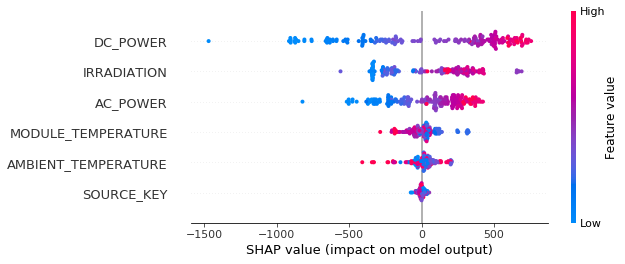

In [11]:
explainer0 = shap.TreeExplainer(xgb_reg)
values0 = explainer0.shap_values(X_test)

shap.summary_plot(values0,X_test)

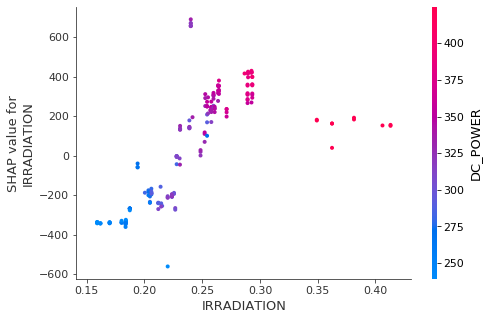

In [12]:
shap.dependence_plot('IRRADIATION', values0, X_test, interaction_index="DC_POWER")

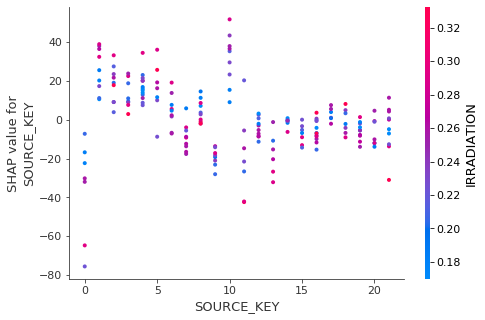

In [13]:
shap.dependence_plot('SOURCE_KEY', values0, X_test, interaction_index="IRRADIATION")

The model developed from this random selection of data results in very high training and test scores suggesting that the model is potentially overfit to the data.

Using shap to explain the feature importance shows DC power to be the top factor followed by IRRADIATION, with the individual inverter SOURCE_KEY having the lowest prevelance to the prediction.

In [14]:
xgbreg = xgb.XGBRegressor(alpha=10, objective='reg:squarederror', base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1390267628526533, max_delta_step=0, max_depth=3,
             min_child_weight=14, monotone_constraints='()',
             n_estimators=5000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
xgbreg.fit(X_in, y_in, eval_set=[(X_in,y_in),(X_external,y_external)],early_stopping_rounds=50)
preds = xgbreg.predict(X_external)
print("r2 Accuracy: {}".format(r2_score(y_external,preds)))

[0]	validation_0-rmse:6354.92676	validation_1-rmse:6110.76611
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:5479.49170	validation_1-rmse:5275.86816
[2]	validation_0-rmse:4726.18408	validation_1-rmse:4588.84814
[3]	validation_0-rmse:4076.91724	validation_1-rmse:3982.35669
[4]	validation_0-rmse:3518.60156	validation_1-rmse:3467.02173
[5]	validation_0-rmse:3037.68774	validation_1-rmse:3007.25806
[6]	validation_0-rmse:2623.67773	validation_1-rmse:2591.10474
[7]	validation_0-rmse:2267.67578	validation_1-rmse:2256.93408
[8]	validation_0-rmse:1961.08264	validation_1-rmse:1952.24866
[9]	validation_0-rmse:1696.65405	validation_1-rmse:1707.25952
[10]	validation_0-rmse:1469.39685	validation_1-rmse:1495.29273
[11]	validation_0-rmse:1274.23450	validation_1-rmse:1301.52710
[12]	validation_0-rmse:1105.45825	validation_1-rmse:1147.26050
[13]	validation_0-rmse:961.51172

[132]	validation_0-rmse:81.26720	validation_1-rmse:272.44537
[133]	validation_0-rmse:80.85488	validation_1-rmse:272.41489
[134]	validation_0-rmse:80.55252	validation_1-rmse:272.33444
[135]	validation_0-rmse:80.41686	validation_1-rmse:272.22662
[136]	validation_0-rmse:80.26846	validation_1-rmse:271.48535
[137]	validation_0-rmse:79.74363	validation_1-rmse:271.03525
[138]	validation_0-rmse:79.45161	validation_1-rmse:270.46973
[139]	validation_0-rmse:79.13483	validation_1-rmse:271.04797
[140]	validation_0-rmse:78.88789	validation_1-rmse:270.05173
[141]	validation_0-rmse:78.78822	validation_1-rmse:270.08957
[142]	validation_0-rmse:78.14469	validation_1-rmse:269.79861
[143]	validation_0-rmse:77.74226	validation_1-rmse:268.48721
[144]	validation_0-rmse:77.34176	validation_1-rmse:267.08597
[145]	validation_0-rmse:77.06695	validation_1-rmse:267.03781
[146]	validation_0-rmse:76.89260	validation_1-rmse:267.06393
[147]	validation_0-rmse:76.71729	validation_1-rmse:266.53940
[148]	validation_0-rmse:

[267]	validation_0-rmse:56.03491	validation_1-rmse:255.19287
[268]	validation_0-rmse:55.93965	validation_1-rmse:255.43988
[269]	validation_0-rmse:55.80651	validation_1-rmse:255.33990
[270]	validation_0-rmse:55.66970	validation_1-rmse:255.32127
[271]	validation_0-rmse:55.63001	validation_1-rmse:255.26901
[272]	validation_0-rmse:55.45172	validation_1-rmse:255.12764
[273]	validation_0-rmse:55.38619	validation_1-rmse:255.11327
[274]	validation_0-rmse:55.33270	validation_1-rmse:255.12160
[275]	validation_0-rmse:55.26358	validation_1-rmse:254.76386
[276]	validation_0-rmse:55.11036	validation_1-rmse:254.65903
[277]	validation_0-rmse:54.84404	validation_1-rmse:254.72066
[278]	validation_0-rmse:54.72247	validation_1-rmse:254.64711
[279]	validation_0-rmse:54.68808	validation_1-rmse:254.60156
[280]	validation_0-rmse:54.55969	validation_1-rmse:254.73596
[281]	validation_0-rmse:54.46934	validation_1-rmse:254.71780
[282]	validation_0-rmse:54.42761	validation_1-rmse:254.69362
[283]	validation_0-rmse:

[402]	validation_0-rmse:46.34619	validation_1-rmse:251.88126
[403]	validation_0-rmse:46.31807	validation_1-rmse:251.84006
[404]	validation_0-rmse:46.25583	validation_1-rmse:251.92851
[405]	validation_0-rmse:46.20091	validation_1-rmse:251.92850
[406]	validation_0-rmse:46.15565	validation_1-rmse:251.62668
[407]	validation_0-rmse:46.13428	validation_1-rmse:251.61717
[408]	validation_0-rmse:46.06255	validation_1-rmse:251.62161
[409]	validation_0-rmse:46.01778	validation_1-rmse:251.45308
[410]	validation_0-rmse:45.99770	validation_1-rmse:251.44421
[411]	validation_0-rmse:45.96812	validation_1-rmse:251.45138
[412]	validation_0-rmse:45.92547	validation_1-rmse:251.38875
[413]	validation_0-rmse:45.89075	validation_1-rmse:251.24640
[414]	validation_0-rmse:45.86988	validation_1-rmse:251.25102
[415]	validation_0-rmse:45.82325	validation_1-rmse:251.17497
[416]	validation_0-rmse:45.79400	validation_1-rmse:251.11421
[417]	validation_0-rmse:45.76724	validation_1-rmse:251.08127
[418]	validation_0-rmse:

[537]	validation_0-rmse:41.04635	validation_1-rmse:248.48068
[538]	validation_0-rmse:41.01265	validation_1-rmse:248.46823
[539]	validation_0-rmse:41.00436	validation_1-rmse:248.46004
[540]	validation_0-rmse:40.98969	validation_1-rmse:248.55998
[541]	validation_0-rmse:40.90471	validation_1-rmse:248.47633
[542]	validation_0-rmse:40.89345	validation_1-rmse:248.48051
[543]	validation_0-rmse:40.85943	validation_1-rmse:248.67802
[544]	validation_0-rmse:40.84640	validation_1-rmse:248.65688
[545]	validation_0-rmse:40.82997	validation_1-rmse:248.70493
[546]	validation_0-rmse:40.75522	validation_1-rmse:248.54616
[547]	validation_0-rmse:40.72872	validation_1-rmse:248.66533
[548]	validation_0-rmse:40.70319	validation_1-rmse:248.72952
[549]	validation_0-rmse:40.69139	validation_1-rmse:248.76338
[550]	validation_0-rmse:40.67552	validation_1-rmse:248.93919
[551]	validation_0-rmse:40.64041	validation_1-rmse:249.04771
[552]	validation_0-rmse:40.63297	validation_1-rmse:248.94003
[553]	validation_0-rmse:

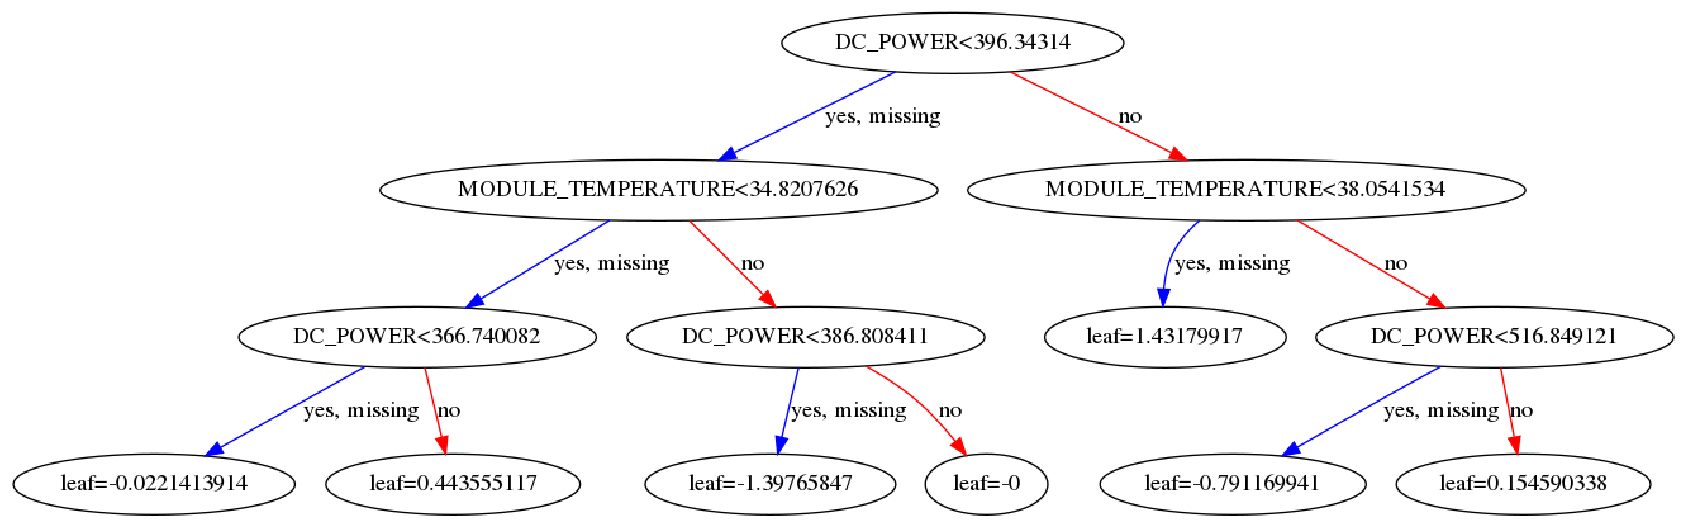

In [15]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(xgbreg, num_trees=534, ax = ax)
plt.show()

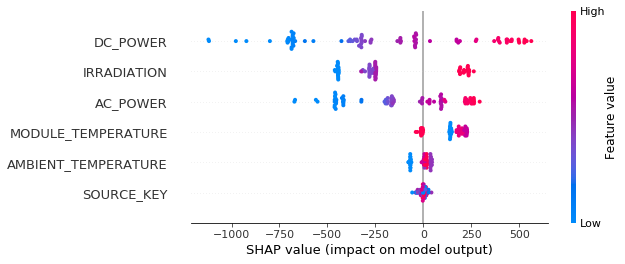

In [16]:
explainer1 = shap.TreeExplainer(xgbreg)
values1 = explainer1.shap_values(X_external)

shap.summary_plot(values1,X_external)

The model developed to predict the next four days has the same feature importance.

In [17]:
df_no , ex_nopp = fourwks_n(res1_nopp,4)
df_useful = ex_nopp.drop(['AC_POWER','DC_POWER','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','IRRADIATION'],axis=1)
df_useful.reset_index(drop=True, inplace=True)
df_predictions = pd.DataFrame({'preds':preds})
df_predictions.reset_index(drop=True, inplace=True)
df_comp = pd.concat([df_useful,df_predictions],axis=1)
df_comp

,SOURCE_KEY,DATE,DAILY_YIELD,preds
0,1BY6WEcLGh8j5v7,2020-06-12,5441.0,5417.527832
1,1IF53ai7Xc0U56Y,2020-06-12,5903.0,5832.082520
2,3PZuoBAID5Wc2HD,2020-06-12,5900.0,5817.240234
3,7JYdWkrLSPkdwr4,2020-06-12,5753.0,5749.225098
4,McdE0feGgRqW7Ca,2020-06-12,5955.0,5865.822266
...,...,...,...,...
83,uHbuxQJl8lW7ozc,2020-06-15,6906.0,6750.607422
84,wCURE6d3bPkepu2,2020-06-15,6746.0,6740.673828
85,z9Y9gH1T5YWrNuG,2020-06-15,6716.0,6734.671875
86,zBIq5rxdHJRwDNY,2020-06-15,6696.0,6740.914551


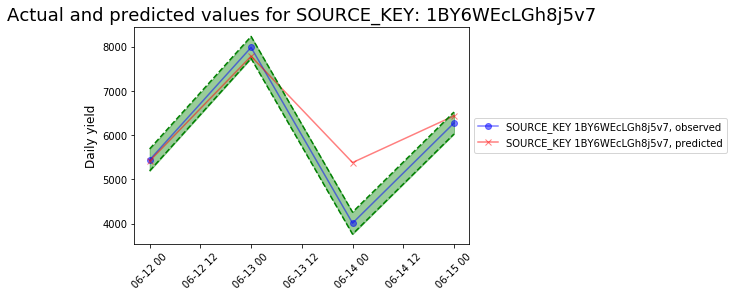

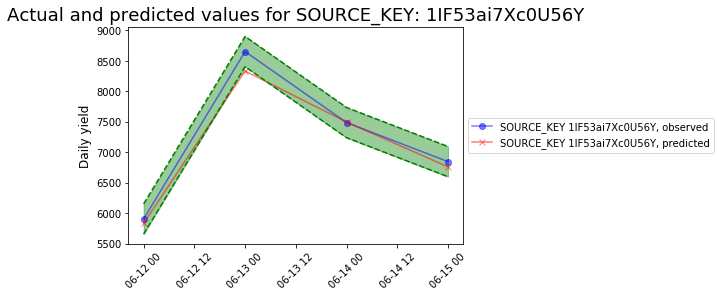

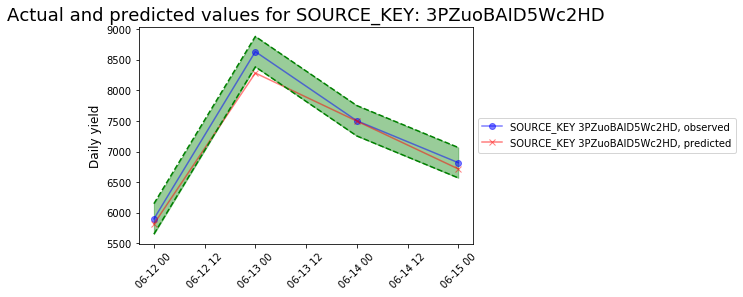

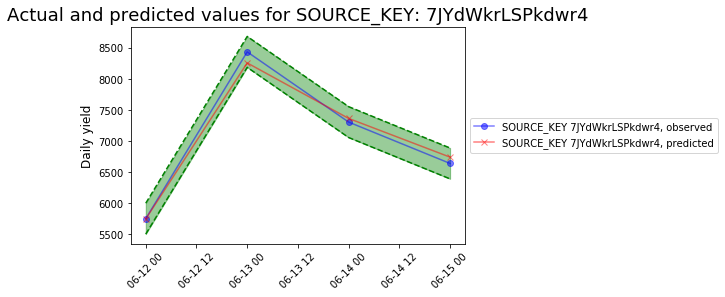

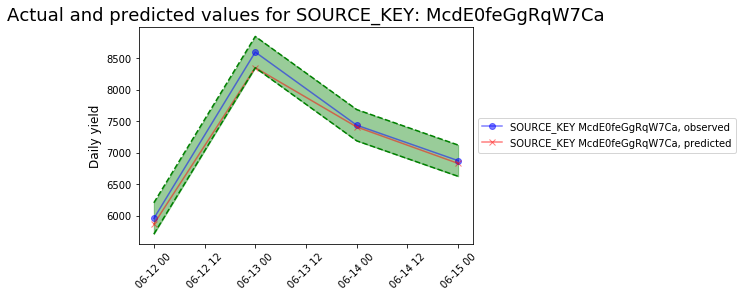

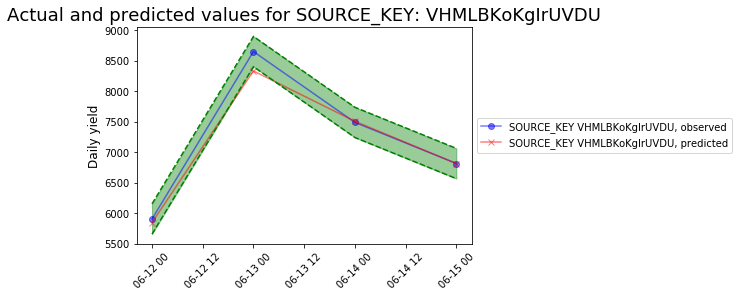

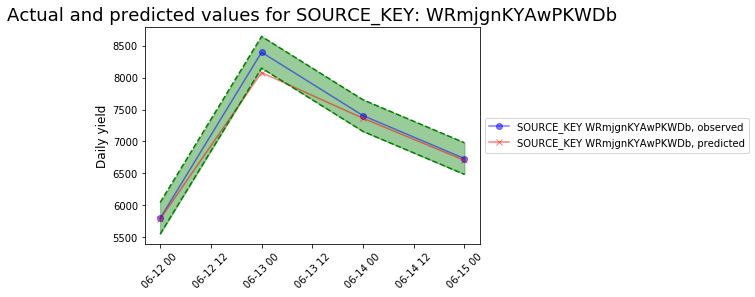

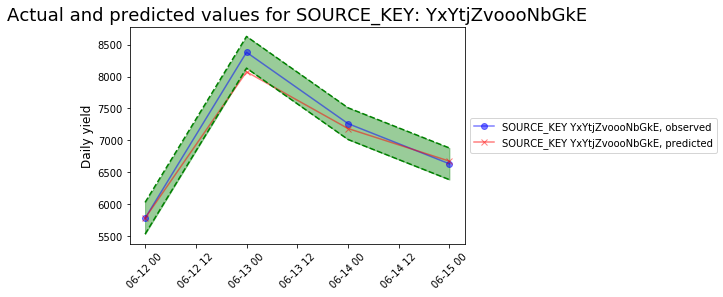

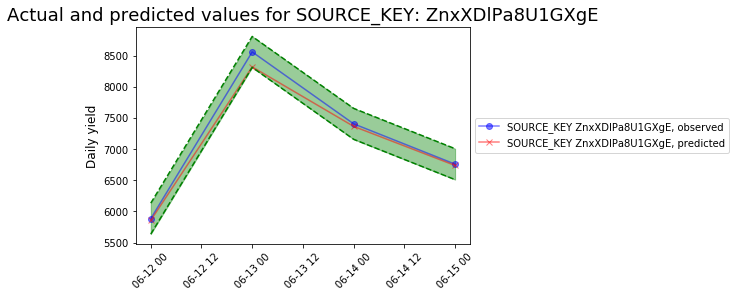

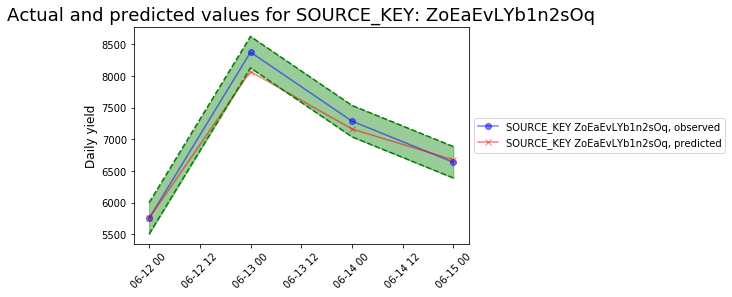

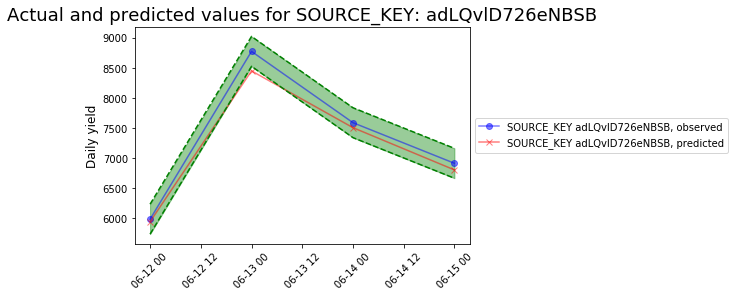

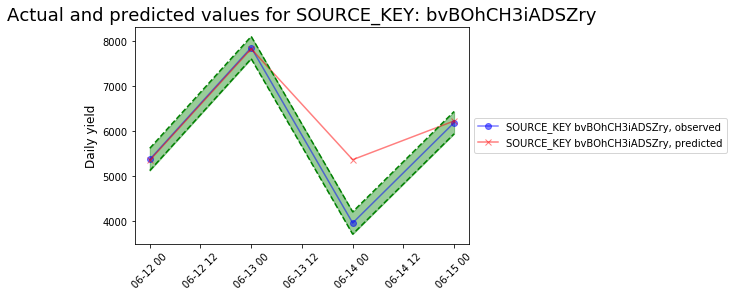

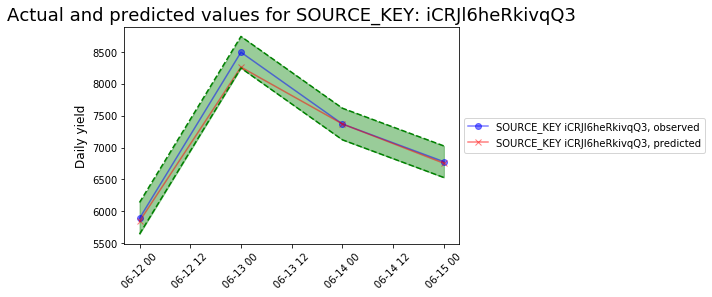

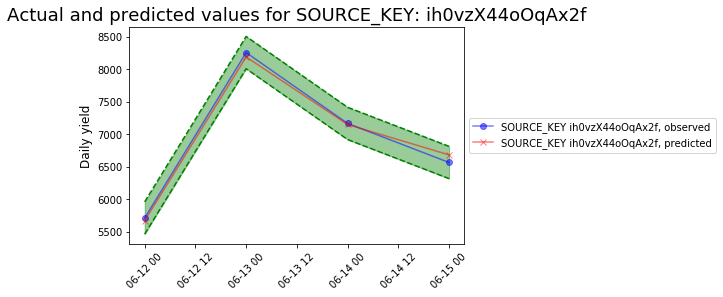

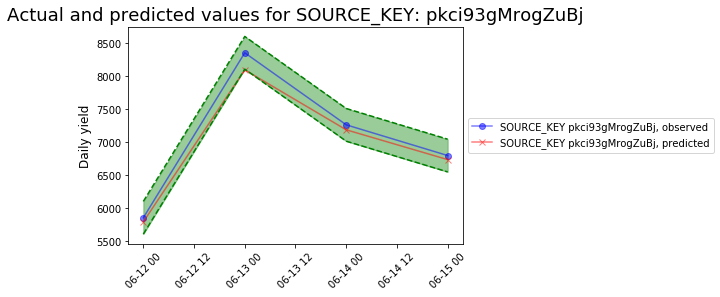

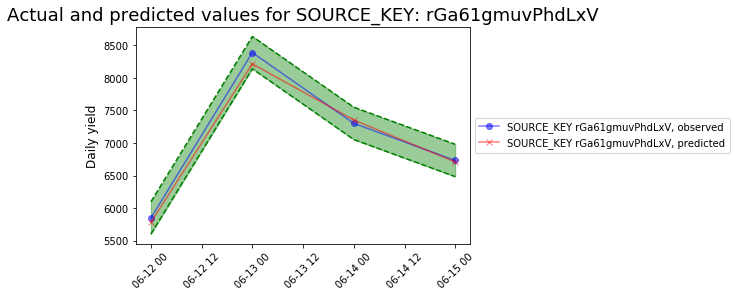

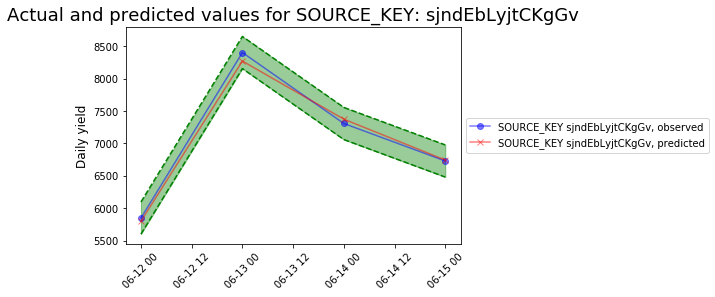

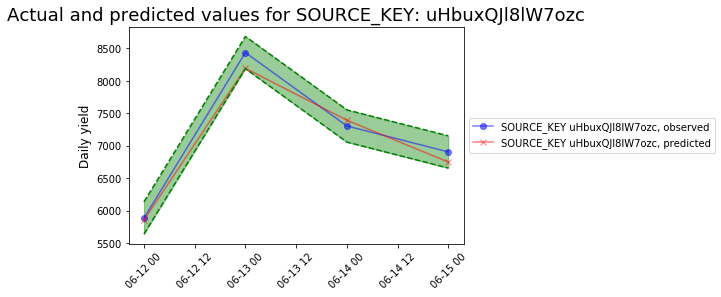

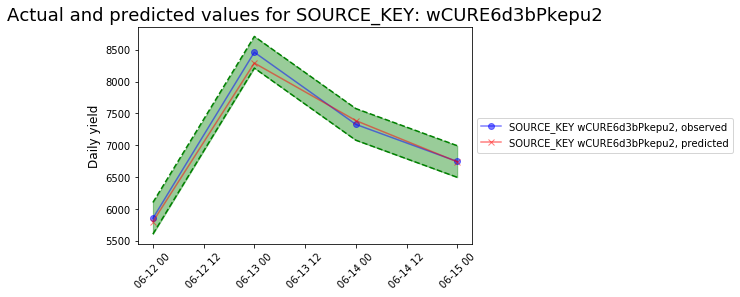

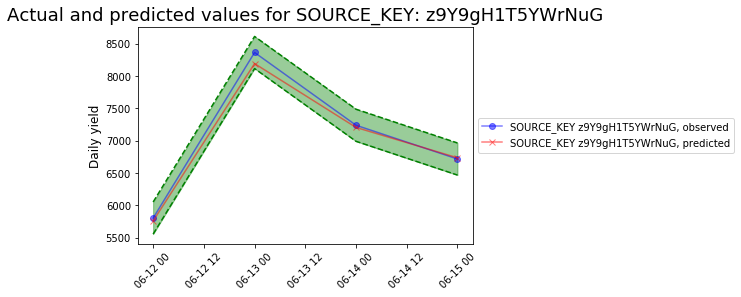

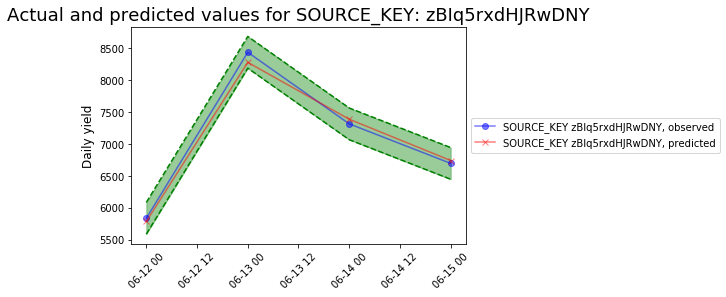

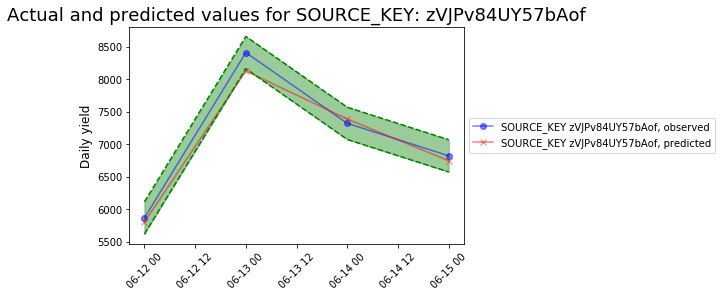

In [18]:
key_list= df_comp.SOURCE_KEY.unique()

for key in key_list:
    df = df_comp[df_comp['SOURCE_KEY']==key]
    plt.plot(df.DATE,df.DAILY_YIELD,label='SOURCE_KEY {}, observed'.format(key),color='blue',alpha=.5,marker='o')
    plt.plot(df.DATE,df.preds, label='SOURCE_KEY {}, predicted'.format(key),color='red',alpha=.5,marker='x')
    plt.plot(df.DATE,df.DAILY_YIELD+248.16400, linestyle='dashed',color='green')
    plt.plot(df.DATE,df.DAILY_YIELD-248.16400, linestyle='dashed',color='green')
    plt.fill_between(df.DATE,df.DAILY_YIELD+248.16400,df.DAILY_YIELD-248.16400,color='green',alpha=.4)
    plt.legend(loc = 'center left', bbox_to_anchor =(1,0.5))
    plt.title('Actual and predicted values for SOURCE_KEY: {}'.format(key), fontsize=18)
    plt.ylabel('Daily yield', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

## Conclusion:
    Using the hyperparameters determined on the entirety of the dataset resulted in a prediction accuracy of 94.6%. The majority of the predictions fall within or just barely outside of the bounds of the root mean squared error. On the 3rd day of predictions the two inverters previously identified as possibly dirty have predicted values that are well above the observed values. This is largely due to the large change in daily yield from day two to three suggesting that our predictions are sensitive to perturbation in the data. We shall further examine this on the dataset for Station 2.
    
    With the information available for Station 1, it is reasonable to conclude that predicting the next few days of yield is possible.